# Ecological index - Regional and hemispheric comparison
- Plot historical reconstruction AEV Index spatial plots
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- July 2025

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

## Load data for eco index

In [6]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load the Present Day Ecoindex Data

In [7]:
file_in = 'ecoindex_historical_future_masked_habitat.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

In [8]:
ds_eco

<xarray.Dataset>
Dimensions:                       (nlat: 36, nlon: 320, time: 150, decades: 14)
Coordinates:
  * nlat                          (nlat) int64 0 1 2 3 4 5 ... 30 31 32 33 34 35
  * nlon                          (nlon) int64 0 1 2 3 4 ... 315 316 317 318 319
  * time                          (time) int64 1950 1951 1952 ... 2097 2098 2099
    TLONG                         (nlat, nlon) float64 ...
    TLAT                          (nlat, nlon) float64 ...
    TAREA                         (nlat, nlon) float64 ...
  * decades                       (decades) int64 1960 1970 1980 ... 2080 2090
Data variables:
    ecoindex_regional_yearly      (time, nlat, nlon) float64 ...
    ecoindex_regional_decadal     (decades, nlat, nlon) float64 ...
    ecoindex_hemispheric_yearly   (time, nlat, nlon) float64 ...
    ecoindex_hemispheric_decadal  (decades, nlat, nlon) float64 ...
    siz_decadal                   (decades, nlat, nlon) float64 ...
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-07-10
    contents:        Ecological Index - historical and future.
    units:           Unitless

In [9]:
# keep regional and decadal version only
eco_pd = ds_eco.ecoindex_regional_decadal

# mask land
eco_pd = eco_pd.where(ds_grid.REGION_MASK == 1)

In [10]:
# mask where it's zero because that's out of SIZ
eco_pd = eco_pd.where(eco_pd > 0)

### Load regional masks

In [11]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [12]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPA planning areas, polynya regions, coastal)
ccamlr_in = ['mpa_plan_1','mpa_plan_2', 'mpa_plan_3', 'mpa_plan_4', 'mpa_plan_5', 'mpa_plan_6', 'mpa_plan_7','mpa_plan_8','mpa_plan_9','mpa_plan_1_mod','mpa_plan_3_mod','mpa_plan_4_mod','mpa_plan_3_4','mpa_plan_7_mod']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1, ds_ccamlr.mpa_plan_2, ds_ccamlr.mpa_plan_3,
                          ds_ccamlr.mpa_plan_4, ds_ccamlr.mpa_plan_5, ds_ccamlr.mpa_plan_6,
                          ds_ccamlr.mpa_plan_7, ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_mod, ds_ccamlr.mpa_plan_4_mod, 
                          ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


### Load shapefiles

In [13]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [14]:
# Read in Antarctic Geography Shapefiles
file_in = 'USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp'

shdf_ant = gpd.read_file(dir_in+file_in)
# Important: convert the projection from the shapefile one to the cartopy one 
shdf_ant = shdf_ant.to_crs(ccrs.SouthPolarStereo())

## Plot figures - AEV spatial

In [15]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [16]:
# get lat/lon info for plotting
lons = ds_grid.TLONG
lats = ds_grid.TLAT

### Set plotting ranges, etc.
- All EcoIndex values go from 0 to 1

In [17]:
# set some plotting info
cmap_in = cmocean.cm.deep
vmin_in = 0.0
vmax_in = 1.0
# set contour levels
levels_in = np.arange(0,1.1,0.1)
levels_in_ctr = np.arange(0,3,1)

In [18]:
# make arrays for the Amundsen/Peninsula region
lats_bound = np.arange(-73, -50, 1)
#lats_bound
lons_bound = np.linspace(275, 275, lats_bound.shape[0])
#lons_bound

### Save plot

In [19]:
# set path for figure output
dir_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/ecoindex_figures/version_6/'

In [20]:
eco_pd

<xarray.DataArray 'ecoindex_regional_decadal' (decades: 14, nlat: 36, nlon: 320)>
dask.array<where, shape=(14, 36, 320), dtype=float64, chunksize=(14, 36, 320), chunktype=numpy.ndarray>
Coordinates:
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
    TAREA    (nlat, nlon) float64 1.125e+13 1.125e+13 ... 3.656e+13 3.656e+13
  * decades  (decades) int64 1960 1970 1980 1990 2000 ... 2060 2070 2080 2090
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>

## Pcolormesh

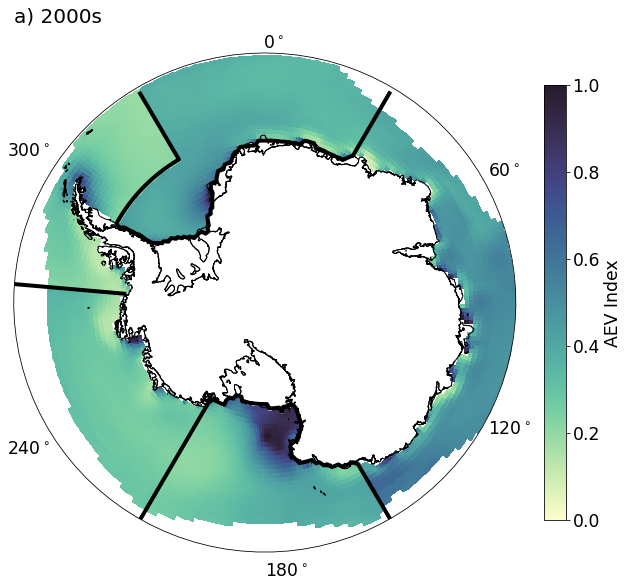

In [21]:
### Plot Decadal AEV - 2000s
dec = 2000

fout = 'SFigure_AEV_regional_'+str(dec)
# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('a) '+str(dec)+'s', y=1.05, loc='left',fontsize=20)
### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle('a) Hemispheric Scaling',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

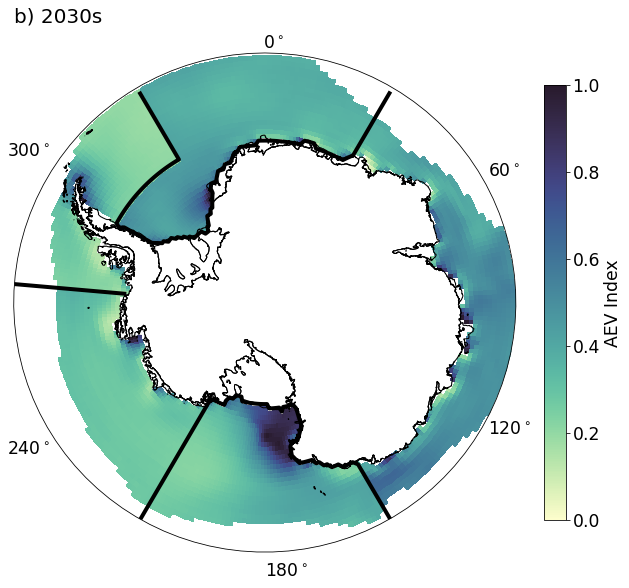

In [22]:
### Plot Decadal AEV - 2030s
dec = 2030

fout = 'SFigure_AEV_regional_'+str(dec)
# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('b) '+str(dec)+'s', y=1.05, loc='left',fontsize=20)
### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle('a) Hemispheric Scaling',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

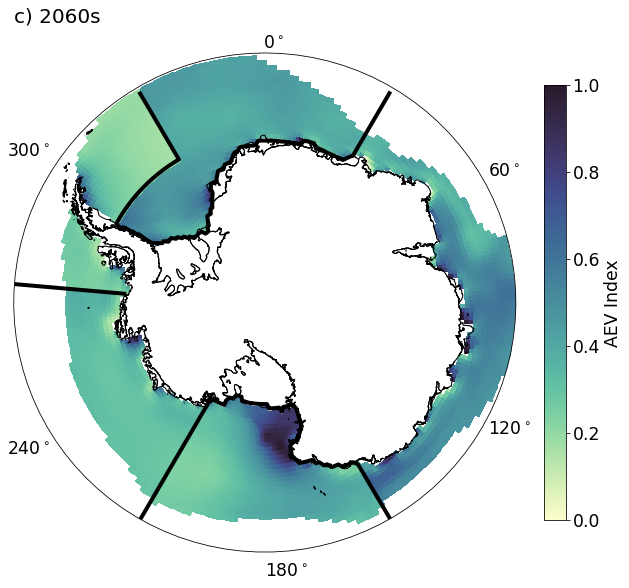

In [23]:
### Plot Decadal AEV - 2060s
dec = 2060

fout = 'SFigure_AEV_regional_'+str(dec)
# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('c) '+str(dec)+'s', y=1.05, loc='left',fontsize=20)
### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle('a) Hemispheric Scaling',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

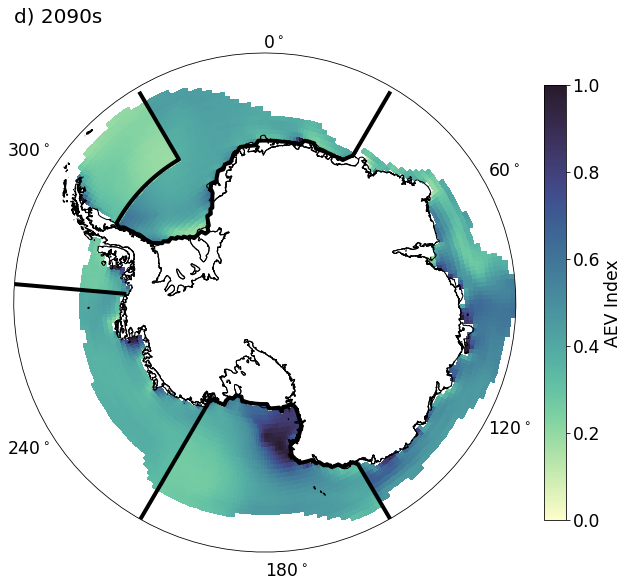

In [24]:
### Plot Decadal AEV - 2090s
dec = 2090

fout = 'SFigure_AEV_regional_'+str(dec)
# get data to plot
data_plt = eco_pd.sel(decades=dec)

# Plot
# create figure
fig = plt.figure(figsize=(10,10))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())
ax.set_title('d) '+str(dec)+'s', y=1.05, loc='left',fontsize=20)
### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.pcolormesh(lon,lat,field,
                 cmap=cmap_in,                      
                 vmax=vmax_in,vmin=vmin_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='vertical',fraction=0.05,pad=0.05,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_ylabel('AEV Index',fontsize='xx-large')

### Add Longitude Labels
# 0 Lon
ax.text(-0.5,-59.5, r'0$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 60 Lon
ax.text(60.0,-59.5, r'60$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 120 Lon
ax.text(120,-59.5, r'120$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 180 Lon
ax.text(180.0,-58.0, r'180$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 240 Lon
ax.text(240,-55.0, r'240$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
# 300 Lon
ax.text(300.0,-55.0, r'300$^\circ$',
        color='black', fontsize = 'xx-large', transform=ccrs.PlateCarree())
### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=4,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=4,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
#fig.suptitle('a) Hemispheric Scaling',fontsize=20, y=0.91)  
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

In [25]:
### Plot Present Day Hemispheric AEV Index
fout = 'Figure_1_AEV_hemi'
# get data to plot
data_plt = eco_pd_hemi

# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.contourf(lon,lat,field,
                 cmap=cmap_in,                      
                 levels=levels_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('AEV Index',fontsize='xx-large')

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=10)

# Finalize figure and save
fig.suptitle('a) Hemispheric Scaling',fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

NameError: name 'eco_pd_hemi' is not defined

In [ ]:
### Plot Present Day Regional AEV Index
fout = 'Figure_1_AEV_region'
# get data to plot
data_plt = eco_pd

# Plot
# create figure
fig = plt.figure(figsize=(20,20))
        
# plot the region as subplots - note it's nrow x ncol x index (starting upper left)
ax = fig.add_subplot(1,1,1, projection = ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([0.005, 360, -90, -60], crs=ccrs.PlateCarree())

### Plot Ecoindex
lon, lat, field = utils.adjust_pop_grid(lons,lats,data_plt)
this=ax.contourf(lon,lat,field,
                 cmap=cmap_in,                      
                 levels=levels_in,
                 transform=ccrs.PlateCarree())
cbar = ax.figure.colorbar(this,orientation='horizontal',extend='max',fraction=0.05,pad=0.01,shrink=0.8)
cbar.ax.tick_params(labelsize='xx-large')
cbar.ax.set_xlabel('AEV Index',fontsize='xx-large')

### Add regional domain lines
# Amundsen/Antarctic Peninsula boundary - along Longitude
ax.plot(lons_bound,lats_bound,
        color='black',linestyle='solid',linewidth=3,transform=ccrs.PlateCarree())
# Weddell Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_3_4').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 
# Ross Sea
lon, lat, field = utils.adjust_pop_grid(lons, lats, ccamlr_masks.sel(region='mpa_plan_8').fillna(0))
this1=ax.contour(lon,lat,field,
                 colors='black',linestyles='solid',linewidths=3,
                 levels=levels_in_ctr,transform=ccrs.PlateCarree()) 

# Add shapefile coastlines
ax.add_geometries(shdf_ant.geometry , ccrs.SouthPolarStereo(), facecolor='none', edgecolor='black',linewidth=1, zorder=100)

# Finalize figure and save
fig.suptitle('b) Regional Scaling',fontsize=20, y=0.91)  
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)